<ipython-input-5-650ce10272ae>:313: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


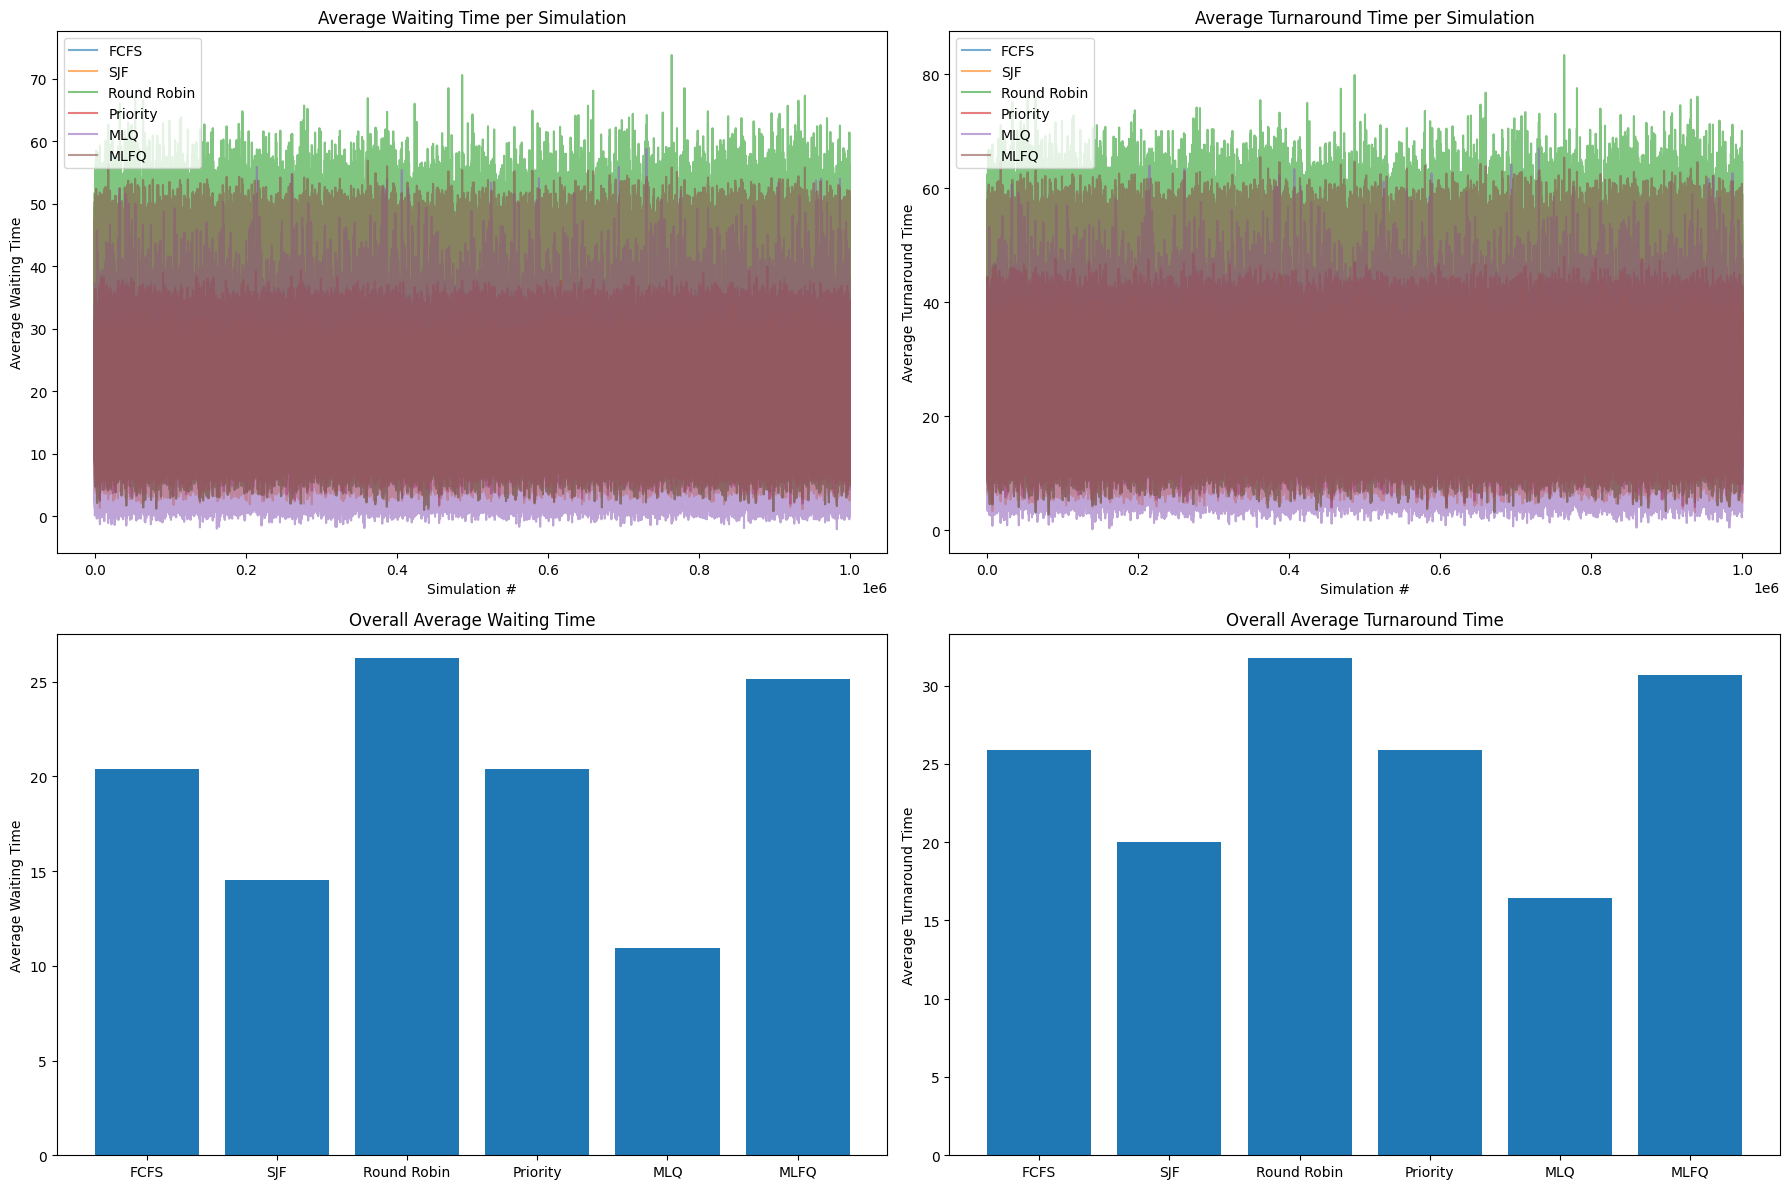

Total code execution time: 248.16672945022583


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time


start_time = time.time()

# Define Process class
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=5):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.priority = priority  # Lower value means higher priority
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.remaining_time = burst_time  # For algorithms that track remaining time

# FCFS Scheduling Function
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0

    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.burst_time + process.waiting_time

        current_time += process.burst_time

        total_waiting_time += process.waiting_time
        total_turnaround_time += process.turnaround_time

    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# SJF Scheduling Function
def sjf_scheduling(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []

    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)

        if ready_queue:
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)

            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time

            current_time += current_process.burst_time
            completed += 1

            total_waiting_time += current_process.waiting_time
            total_turnaround_time += current_process.turnaround_time
        else:
            current_time += 1

    return total_waiting_time / n, total_turnaround_time / n

# Round Robin Scheduling Function
def round_robin_scheduling(processes, time_quantum=4):
    current_time = 0
    queue = processes[:]
    for process in queue:
        process.remaining_time = process.burst_time  # Track remaining time for each process
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)

    while queue:
        process = queue.pop(0)

        if process.remaining_time <= time_quantum:
            current_time += process.remaining_time
            process.waiting_time = current_time - process.arrival_time - process.burst_time
            process.turnaround_time = current_time - process.arrival_time
            total_waiting_time += process.waiting_time
            total_turnaround_time += process.turnaround_time
        else:
            current_time += time_quantum
            process.remaining_time -= time_quantum
            queue.append(process)  # Re-add process to the queue

    return total_waiting_time / n, total_turnaround_time / n


# Priority Scheduling Function
def priority_scheduling(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.priority))
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)

    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.burst_time + process.waiting_time

        current_time += process.burst_time
        total_waiting_time += process.waiting_time
        total_turnaround_time += process.turnaround_time

    return total_waiting_time / n, total_turnaround_time / n


# Multilevel Queue Scheduling Function
def multilevel_queue_scheduling(processes, time_quantum=4):
    # Define queues: higher-priority and lower-priority
    high_priority = [p for p in processes if p.priority <= 3]
    low_priority = [p for p in processes if p.priority > 3]
    total_waiting_time, total_turnaround_time = 0, 0
    n = len(processes)

    # First process high priority queue with Round Robin
    if high_priority:
        rr_wait, rr_turnaround = round_robin_scheduling(high_priority, time_quantum)
        total_waiting_time += rr_wait * len(high_priority)
        total_turnaround_time += rr_turnaround * len(high_priority)

    # Then process low priority with FCFS
    if low_priority:
        fcfs_wait, fcfs_turnaround = fcfs_scheduling(low_priority)
        total_waiting_time += fcfs_wait * len(low_priority)
        total_turnaround_time += fcfs_turnaround * len(low_priority)

    return total_waiting_time / n, total_turnaround_time / n


# Multilevel Feedback Queue Scheduling Function
def multilevel_feedback_queue_scheduling(processes, time_quantum=4, num_queues=3):
    queues = [[] for _ in range(num_queues)]
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)

    for process in processes:
        process.remaining_time = process.burst_time
        queues[0].append(process)

    for i in range(num_queues):
        while queues[i]:
            process = queues[i].pop(0)
            quantum = time_quantum * (2 ** i)
            if process.remaining_time > quantum:
                current_time += quantum
                process.remaining_time -= quantum
                if i < num_queues - 1:
                    queues[i + 1].append(process)
                else:
                    queues[i].append(process)
            else:
                current_time += process.remaining_time
                process.waiting_time = current_time - process.arrival_time - process.burst_time
                process.turnaround_time = current_time - process.arrival_time
                total_waiting_time += process.waiting_time
                total_turnaround_time += process.turnaround_time

    return total_waiting_time / n, total_turnaround_time / n


# Update process generation to include random priority
def generate_random_processes(num_processes):
    return [Process(pid=i+1, arrival_time=random.randint(0, 10), burst_time=random.randint(1, 10), priority=random.randint(1, 5)) for i in range(num_processes)]

# Extended run_large_scale_simulation with additional algorithms
def run_large_scale_simulation(num_simulations=100000, num_processes=10, time_quantum=4):
    fcfs_waiting_times = np.zeros(num_simulations)
    fcfs_turnaround_times = np.zeros(num_simulations)
    sjf_waiting_times = np.zeros(num_simulations)
    sjf_turnaround_times = np.zeros(num_simulations)
    rr_waiting_times = np.zeros(num_simulations)
    rr_turnaround_times = np.zeros(num_simulations)
    priority_waiting_times = np.zeros(num_simulations)
    priority_turnaround_times = np.zeros(num_simulations)
    mlq_waiting_times = np.zeros(num_simulations)
    mlq_turnaround_times = np.zeros(num_simulations)
    mlfq_waiting_times = np.zeros(num_simulations)
    mlfq_turnaround_times = np.zeros(num_simulations)

    for i in range(num_simulations):
        processes = generate_random_processes(num_processes)

        # FCFS
        fcfs_avg_waiting, fcfs_avg_turnaround = fcfs_scheduling(
            [Process(p.pid, p.arrival_time, p.burst_time) for p in processes]
        )
        fcfs_waiting_times[i] = fcfs_avg_waiting
        fcfs_turnaround_times[i] = fcfs_avg_turnaround

        # SJF
        sjf_avg_waiting, sjf_avg_turnaround = sjf_scheduling(
            [Process(p.pid, p.arrival_time, p.burst_time) for p in processes]
        )
        sjf_waiting_times[i] = sjf_avg_waiting
        sjf_turnaround_times[i] = sjf_avg_turnaround

        # Round Robin
        rr_avg_waiting, rr_avg_turnaround = round_robin_scheduling(
            [Process(p.pid, p.arrival_time, p.burst_time) for p in processes], time_quantum
        )
        rr_waiting_times[i] = rr_avg_waiting
        rr_turnaround_times[i] = rr_avg_turnaround

        # Priority Scheduling
        priority_avg_waiting, priority_avg_turnaround = priority_scheduling(
            [Process(p.pid, p.arrival_time, p.burst_time, random.randint(1, 5)) for p in processes]
        )
        priority_waiting_times[i] = priority_avg_waiting
        priority_turnaround_times[i] = priority_avg_turnaround

        # Multilevel Queue Scheduling
        mlq_avg_waiting, mlq_avg_turnaround = multilevel_queue_scheduling(
            [Process(p.pid, p.arrival_time, p.burst_time, random.randint(1, 5)) for p in processes], time_quantum
        )
        mlq_waiting_times[i] = mlq_avg_waiting
        mlq_turnaround_times[i] = mlq_avg_turnaround

        # Multilevel Feedback Queue Scheduling
        mlfq_avg_waiting, mlfq_avg_turnaround = multilevel_feedback_queue_scheduling(
            [Process(p.pid, p.arrival_time, p.burst_time) for p in processes], time_quantum
        )
        mlfq_waiting_times[i] = mlfq_avg_waiting
        mlfq_turnaround_times[i] = mlfq_avg_turnaround

    return (fcfs_waiting_times, fcfs_turnaround_times, sjf_waiting_times, sjf_turnaround_times,
            rr_waiting_times, rr_turnaround_times, priority_waiting_times, priority_turnaround_times,
            mlq_waiting_times, mlq_turnaround_times, mlfq_waiting_times, mlfq_turnaround_times)

# Visualization Function
def visualize_large_scale_results(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                  rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                                  mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround):

    # Overall averages
    overall_fcfs_waiting = np.mean(fcfs_waiting)
    overall_fcfs_turnaround = np.mean(fcfs_turnaround)
    overall_sjf_waiting = np.mean(sjf_waiting)
    overall_sjf_turnaround = np.mean(sjf_turnaround)
    overall_rr_waiting = np.mean(rr_waiting)
    overall_rr_turnaround = np.mean(rr_turnaround)
    overall_priority_waiting = np.mean(priority_waiting)
    overall_priority_turnaround = np.mean(priority_turnaround)
    overall_mlq_waiting = np.mean(mlq_waiting)
    overall_mlq_turnaround = np.mean(mlq_turnaround)
    overall_mlfq_waiting = np.mean(mlfq_waiting)
    overall_mlfq_turnaround = np.mean(mlfq_turnaround)

    # Line charts for Waiting Time
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 2, 1)
    plt.plot(fcfs_waiting, label="FCFS", alpha=0.6)
    plt.plot(sjf_waiting, label="SJF", alpha=0.6)
    plt.plot(rr_waiting, label="Round Robin", alpha=0.6)
    plt.plot(priority_waiting, label="Priority", alpha=0.6)
    plt.plot(mlq_waiting, label="MLQ", alpha=0.6)
    plt.plot(mlfq_waiting, label="MLFQ", alpha=0.6)
    plt.xlabel("Simulation #")
    plt.ylabel("Average Waiting Time")
    plt.title("Average Waiting Time per Simulation")
    plt.legend()

    # Line charts for Turnaround Time
    plt.subplot(2, 2, 2)
    plt.plot(fcfs_turnaround, label="FCFS", alpha=0.6)
    plt.plot(sjf_turnaround, label="SJF", alpha=0.6)
    plt.plot(rr_turnaround, label="Round Robin", alpha=0.6)
    plt.plot(priority_turnaround, label="Priority", alpha=0.6)
    plt.plot(mlq_turnaround, label="MLQ", alpha=0.6)
    plt.plot(mlfq_turnaround, label="MLFQ", alpha=0.6)
    plt.xlabel("Simulation #")
    plt.ylabel("Average Turnaround Time")
    plt.title("Average Turnaround Time per Simulation")
    plt.legend()

    # Overall comparison bar chart for Waiting Time
    plt.subplot(2, 2, 3)
    labels = ["FCFS", "SJF", "Round Robin", "Priority", "MLQ", "MLFQ"]
    waiting_times = [overall_fcfs_waiting, overall_sjf_waiting, overall_rr_waiting,
                     overall_priority_waiting, overall_mlq_waiting, overall_mlfq_waiting]
    plt.bar(labels, waiting_times)
    plt.ylabel("Average Waiting Time")
    plt.title("Overall Average Waiting Time")

    # Overall comparison bar chart for Turnaround Time
    plt.subplot(2, 2, 4)
    turnaround_times = [overall_fcfs_turnaround, overall_sjf_turnaround, overall_rr_turnaround,
                        overall_priority_turnaround, overall_mlq_turnaround, overall_mlfq_turnaround]
    plt.bar(labels, turnaround_times)
    plt.ylabel("Average Turnaround Time")
    plt.title("Overall Average Turnaround Time")

    plt.tight_layout()
    plt.show()

# Execute large-scale simulation and visualize results
(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
 rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
 mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround) = run_large_scale_simulation()

visualize_large_scale_results(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                              rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                              mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround)

end_time = time.time()
total_time = end_time - start_time
print('Total code execution time: {}'.format(total_time))
